# Лабораторная работа №1. Проведение исследований с алгоритмом KNN

## Выбор начальных условий
**Классификация**\
Задача прогноза выживаемости пациентов по клинико-демографическим признакам. Это реальный медико-социальный кейс: возможность раннего выявления групп риска и приоритезация ресурсов. Датасет большой (миллион наблюдений), с бинарными и категориальными факторами, присутствует умеренный дисбаланс классов и пропуски, что приближает задачу к реальной практике.

**Регрессия**\
Прогноз страховых выплат по демографическим и медицинским характеристикам. Это прикладная задача тарификации и оценки рисков в страховых компаниях. Датасет чистый и компактный, что позволяет быстро экспериментировать с моделями, но содержит нелинейные зависимости (курение, BMI, возраст), что требует гибких алгоритмов.

**Метрики классификации**\
Accuracy отражает общую долю верных ответов, но при дисбалансе классов важны Precision и Recall для оценки ошибок разных типов; F1 гармонизирует точность и полноту и полезен при поиске баланса между ложными срабатываниями и пропусками; ROC AUC оценивает способность модели ранжировать объекты при изменении порога и менее чувствителен к дисбалансу.

**Метрики регрессии**\
MAE дает среднюю абсолютную ошибку и интерпретируется в исходных единицах (деньги); RMSE сильнее штрафует крупные ошибки и чувствителен к выбросам; R² показывает долю объясненной вариации и позволяет сравнить модель с константным предсказанием.


Импорт библиотек и базовые настройки
Подключаем инструменты анализа/визуализации, фиксируем рандом и стиль графиков

In [21]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")


Загрузка датасетов\
Читаем CSV: COVID для классификации, insurance для регрессии

In [22]:
covid_path = Path("../datasets/covid.csv")
insurance_path = Path("../datasets/insurance.csv")

df_covid_raw = pd.read_csv(covid_path)
df_insurance_raw = pd.read_csv(insurance_path)


Вспомогательные функции для метрик и таблиц\
Унификация расчета метрик и форматирования итоговых таблиц

In [23]:
def classification_report_dict(y_true, y_pred, y_proba=None):
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            scores["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            scores["roc_auc"] = np.nan
    return scores


def regression_report_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
    }


def show_results_table(results, title):
    print(f"\n{title}")
    display_df = pd.DataFrame(results).T
    display_df = display_df.round(4)
    print(display_df)


Предобработка COVID-датасета под задачу классификации\
Формируем целевую метку смертности, переводим коды пропусков в NaN, выделяем признаки


In [24]:
covid_df = df_covid_raw.copy()
covid_df["died"] = (covid_df["DATE_DIED"] != "9999-99-99").astype(int)
covid_df["COVID_POSITIVE"] = (covid_df["CLASIFFICATION_FINAL"] <= 3).astype(int)
covid_df = covid_df.drop(columns=["DATE_DIED"])

covid_df = covid_df.replace({97: np.nan, 98: np.nan, 99: np.nan})
feature_cols_covid = [col for col in covid_df.columns if col != "died"]

covid_sample = covid_df.sample(n=80000, random_state=RANDOM_STATE)


COVID EDA: целевая переменная, возраст и корреляции\
Базовые распределения и связи с ключевыми признаками

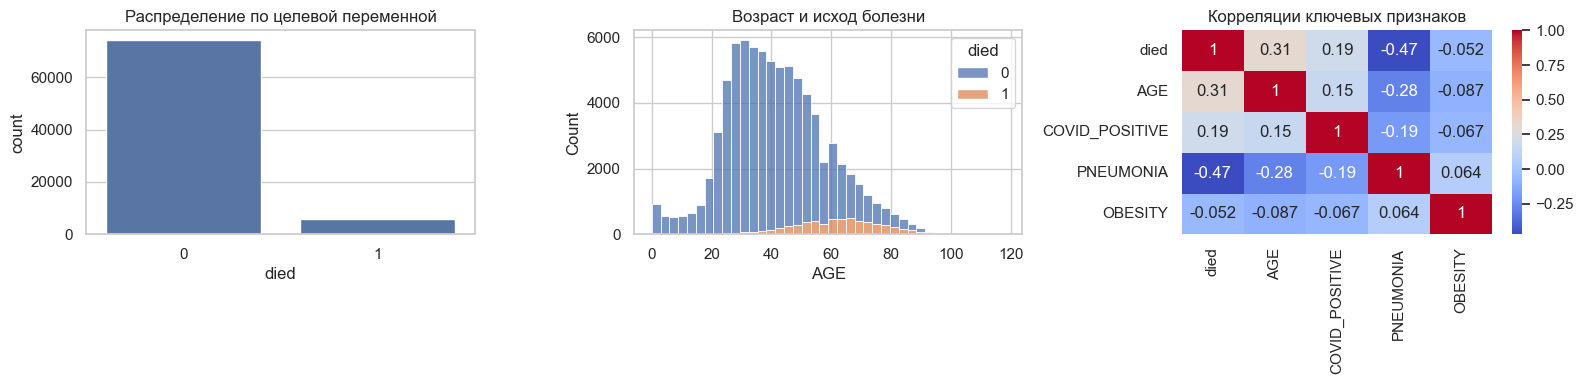

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=covid_sample, x="died", ax=axes[0])
axes[0].set_title("Распределение по целевой переменной")

sns.histplot(
    data=covid_sample,
    x="AGE",
    hue="died",
    multiple="stack",
    bins=40,
    ax=axes[1],
)
axes[1].set_title("Возраст и исход болезни")

corr_subset = covid_sample[["died", "AGE", "COVID_POSITIVE", "PNEUMONIA", "OBESITY"]]
sns.heatmap(corr_subset.corr(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Корреляции ключевых признаков")
plt.tight_layout()
plt.show()


COVID EDA: профиль пациентов и риск-группы\
Смотрим смертность по полу/типу пациента, возрастные распределения, коморбидности

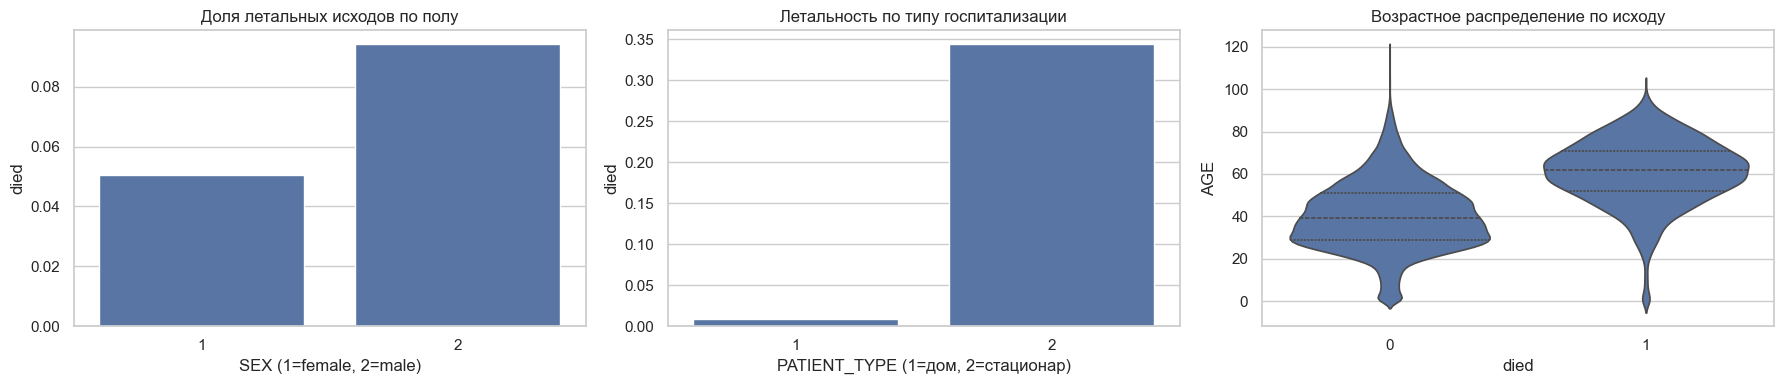

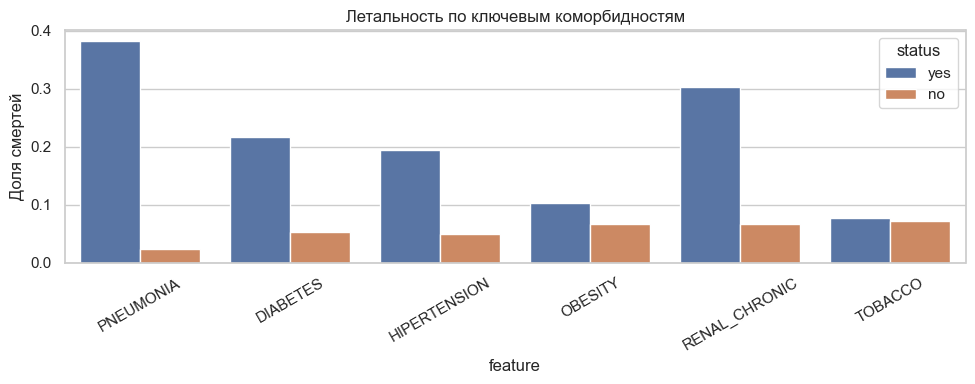

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(
    data=covid_sample,
    x="SEX",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Доля летальных исходов по полу")
axes[0].set_xlabel("SEX (1=female, 2=male)")

sns.barplot(
    data=covid_sample,
    x="PATIENT_TYPE",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Летальность по типу госпитализации")
axes[1].set_xlabel("PATIENT_TYPE (1=дом, 2=стационар)")

sns.violinplot(
    data=covid_sample.sample(80000, random_state=RANDOM_STATE),
    x="died",
    y="AGE",
    inner="quart",
    ax=axes[2],
)
axes[2].set_title("Возрастное распределение по исходу")
plt.tight_layout()
plt.show()

risk_cols = ["PNEUMONIA", "DIABETES", "HIPERTENSION", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

risk_records = []
for col in risk_cols:
    yes_mean = covid_sample.loc[covid_sample[col] == 1, "died"].mean()
    no_mean = covid_sample.loc[covid_sample[col] == 2, "died"].mean()
    risk_records.append({"feature": col, "status": "yes", "mortality": yes_mean})
    risk_records.append({"feature": col, "status": "no", "mortality": no_mean})

risk_df = pd.DataFrame(risk_records)
plt.figure(figsize=(10, 4))
sns.barplot(data=risk_df, x="feature", y="mortality", hue="status")
plt.xticks(rotation=30)
plt.title("Летальность по ключевым коморбидностям")
plt.ylabel("Доля смертей")
plt.tight_layout()
plt.show()


Бейзлайн KNN-классификатор (sklearn)\
Пайплайн: импутация, стандартизация, KNN с фиксированными гиперпараметрами

In [27]:
X_covid = covid_sample[feature_cols_covid]
y_covid = covid_sample["died"]

X_train_covid, X_test_covid, y_train_covid, y_test_covid = train_test_split(
    X_covid, y_covid, test_size=0.2, stratify=y_covid, random_state=RANDOM_STATE
)

cls_baseline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=7, weights="uniform")),
    ]
)

cls_baseline.fit(X_train_covid, y_train_covid)
cls_pred = cls_baseline.predict(X_test_covid)
cls_proba = cls_baseline.predict_proba(X_test_covid)[:, 1]

results_classification = {}
results_classification["baseline_knn"] = classification_report_dict(
    y_test_covid, cls_pred, cls_proba
)


Улучшение классификатора: подбор гиперпараметров KNN\
GridSearchCV по k, весам и метрике расстояния (Манхэттен/Евклид)


In [28]:
param_grid_cls = {
    "knn__n_neighbors": [5, 11, 19],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

cv_cls = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

cls_search = GridSearchCV(
    estimator=cls_baseline,
    param_grid=param_grid_cls,
    scoring="f1",
    cv=cv_cls,
    n_jobs=-1,
)
cls_search.fit(X_train_covid, y_train_covid)

best_cls = cls_search.best_estimator_
best_pred = best_cls.predict(X_test_covid)
best_proba = best_cls.predict_proba(X_test_covid)[:, 1]

results_classification["tuned_knn"] = classification_report_dict(
    y_test_covid, best_pred, best_proba
)


Визуализация подбора гиперпараметров KNN (F1 по k)
Анализируем влияние числа соседей, весов и метрики расстояния

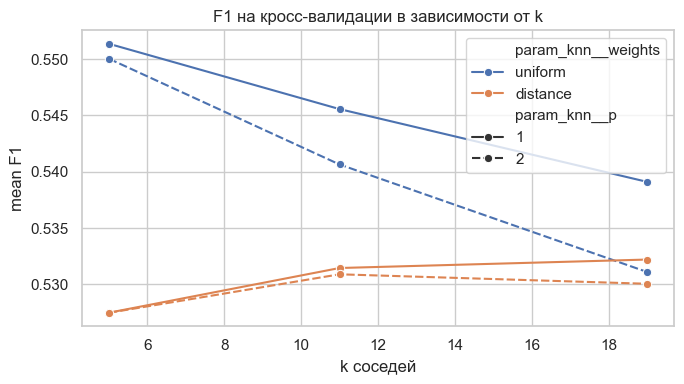

In [29]:
cv_results_cls = pd.DataFrame(cls_search.cv_results_)
cv_results_cls["param_knn__n_neighbors"] = cv_results_cls["param_knn__n_neighbors"].astype(
    int
)

plt.figure(figsize=(7, 4))
sns.lineplot(
    data=cv_results_cls,
    x="param_knn__n_neighbors",
    y="mean_test_score",
    hue="param_knn__weights",
    style="param_knn__p",
    marker="o",
)
plt.title("F1 на кросс-валидации в зависимости от k")
plt.xlabel("k соседей")
plt.ylabel("mean F1")
plt.tight_layout()
plt.show()


Визуализация качества лучшей модели: матрица ошибок\
Confusion matrix помогает понять типичные ошибки после тюнинга


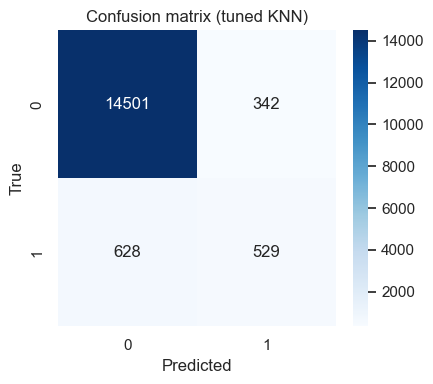

In [30]:
cm = confusion_matrix(y_test_covid, best_pred)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (tuned KNN)")
plt.tight_layout()
plt.show()

Ручная имплементация KNN (классификация и регрессия)\
Кастомные классы для экспериментов без sklearn-реализации

In [31]:
class CustomKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self._X = np.asarray(X, dtype=float)
        self._y = np.asarray(y)
        return self

    def _compute_distances(self, X):
        X = np.asarray(X, dtype=float)
        diff = X[:, None, :] - self._X[None, :, :]
        return np.linalg.norm(diff, ord=self.p, axis=2)

    def predict(self, X):
        dists = self._compute_distances(X)
        idx = np.argpartition(dists, self.n_neighbors, axis=1)[:, : self.n_neighbors]
        neighbors = self._y[idx]
        preds = []
        for row in neighbors:
            values, counts = np.unique(row, return_counts=True)
            preds.append(values[np.argmax(counts)])
        return np.array(preds)

    def predict_proba(self, X):
        dists = self._compute_distances(X)
        idx = np.argpartition(dists, self.n_neighbors, axis=1)[:, : self.n_neighbors]
        neighbors = self._y[idx]
        proba = np.zeros((neighbors.shape[0], len(self.classes_)))
        for i, row in enumerate(neighbors):
            values, counts = np.unique(row, return_counts=True)
            for v, c in zip(values, counts):
                class_idx = np.where(self.classes_ == v)[0][0]
                proba[i, class_idx] = c / self.n_neighbors
        return proba


class CustomKNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p

    def fit(self, X, y):
        self._X = np.asarray(X, dtype=float)
        self._y = np.asarray(y, dtype=float)
        return self

    def _compute_distances(self, X):
        X = np.asarray(X, dtype=float)
        diff = X[:, None, :] - self._X[None, :, :]
        return np.linalg.norm(diff, ord=self.p, axis=2)

    def predict(self, X):
        dists = self._compute_distances(X)
        idx = np.argpartition(dists, self.n_neighbors, axis=1)[:, : self.n_neighbors]
        neighbors = self._y[idx]
        return neighbors.mean(axis=1)


Оценка кастомного KNN для классификации на уменьшенной выборке\
Берем меньший датасет для ускорения и сравниваем с sklearn-версиями

In [32]:
X_small, _, y_small, _ = train_test_split(
    X_covid,
    y_covid,
    train_size=12_000,
    stratify=y_covid,
    random_state=RANDOM_STATE,
)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=RANDOM_STATE,
)

custom_cls_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("model", CustomKNNClassifier(n_neighbors=11, p=2)),
    ]
)

custom_cls_pipeline.fit(X_train_small, y_train_small)
custom_pred = custom_cls_pipeline.predict(X_test_small)
custom_proba = custom_cls_pipeline.predict_proba(X_test_small)[:, 1]

results_classification["custom_knn"] = classification_report_dict(
    y_test_small, custom_pred, custom_proba
)

show_results_table(results_classification, title="Метрики классификации (COVID)")



Метрики классификации (COVID)
              accuracy  precision  recall      f1  roc_auc
baseline_knn    0.9415     0.6327  0.4555  0.5296   0.9085
tuned_knn       0.9394     0.6073  0.4572  0.5217   0.8922
custom_knn      0.9425     0.6765  0.3966  0.5000   0.9119


Предобработка insurance-датасета под регрессию
Разделяем таргет/признаки, настраиваем пайплайн для числовых и категориальных столбцов

In [33]:
insurance_df = df_insurance_raw.copy()
target_reg = insurance_df["charges"]
features_reg = insurance_df.drop(columns=["charges"])

numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


EDA для страховок: распределения и зависимости\
Общий взгляд на выплаты, влияние курения и связь BMI с выплатами

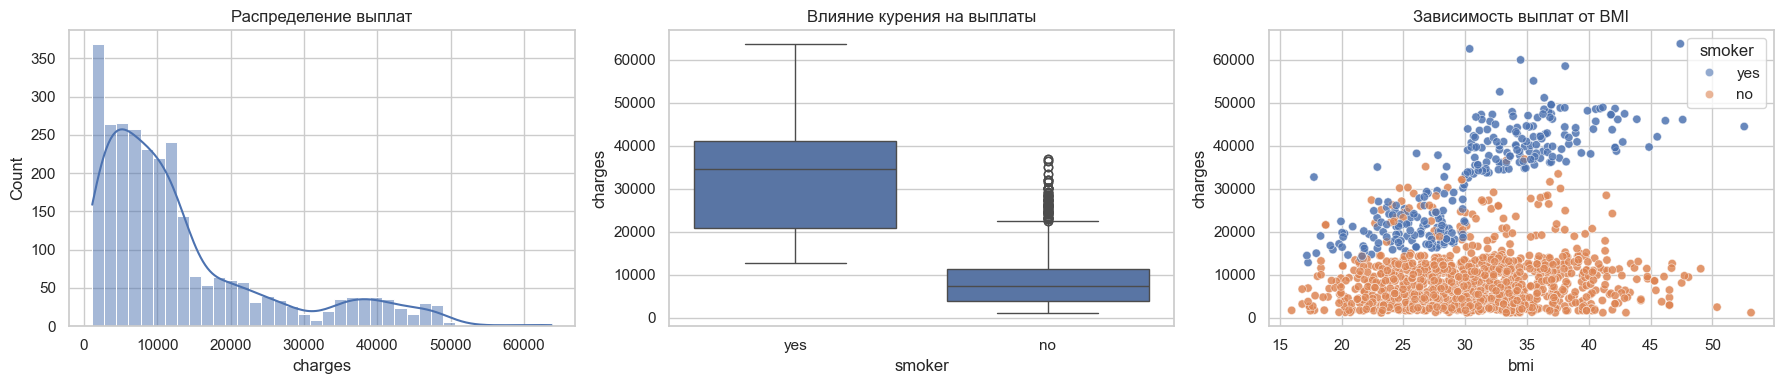

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(insurance_df["charges"], kde=True, ax=axes[0])
axes[0].set_title("Распределение выплат")

sns.boxplot(data=insurance_df, x="smoker", y="charges", ax=axes[1])
axes[1].set_title("Влияние курения на выплаты")

sns.scatterplot(
    data=insurance_df,
    x="bmi",
    y="charges",
    hue="smoker",
    alpha=0.6,
    ax=axes[2],
)
axes[2].set_title("Зависимость выплат от BMI")
plt.tight_layout()
plt.show()


Дополнительные графики по страховкам\
Разбивки по регионам/детям/полу, чтобы увидеть разницу в распределениях


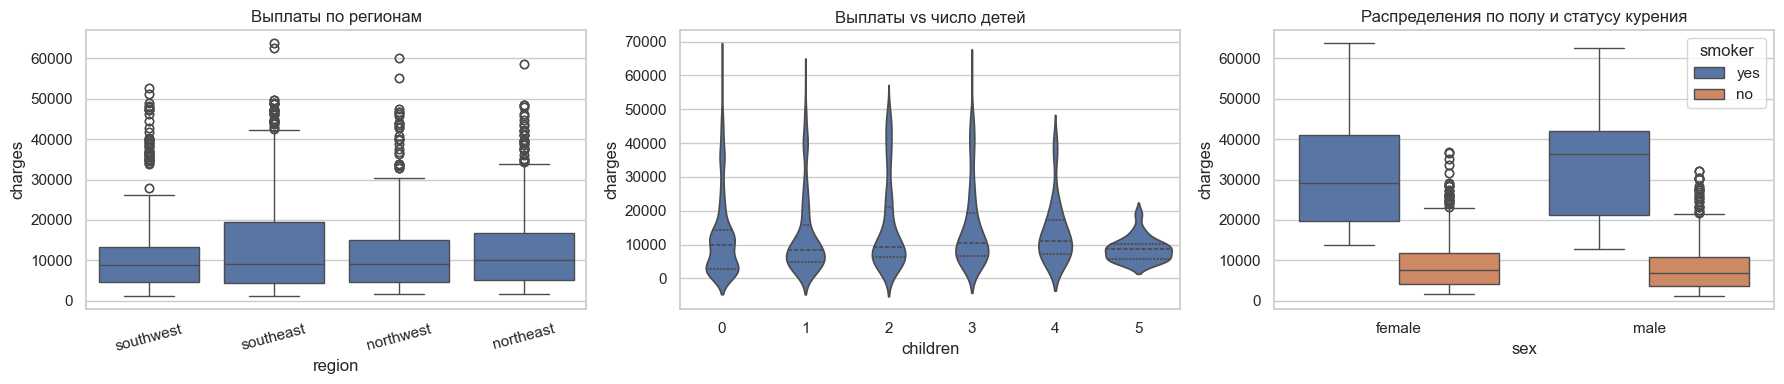

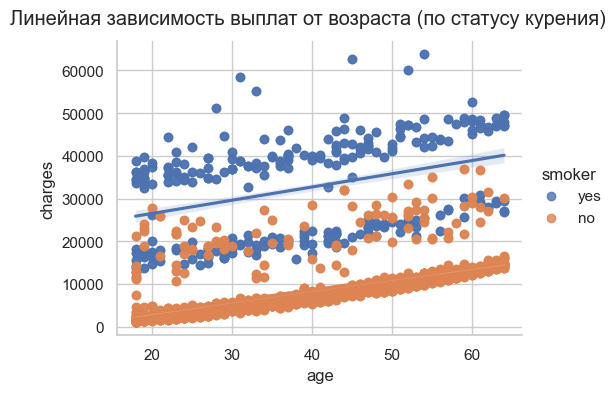

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(data=insurance_df, x="region", y="charges", ax=axes[0])
axes[0].set_title("Выплаты по регионам")
axes[0].tick_params(axis="x", rotation=15)

sns.violinplot(
    data=insurance_df,
    x="children",
    y="charges",
    inner="quart",
    ax=axes[1],
)
axes[1].set_title("Выплаты vs число детей")

sns.boxplot(data=insurance_df, x="sex", y="charges", hue="smoker", ax=axes[2])
axes[2].set_title("Распределения по полу и статусу курения")
plt.tight_layout()
plt.show()

# Тренд выплат по возрасту для курящих/некурящих
age_trend = sns.lmplot(
    data=insurance_df,
    x="age",
    y="charges",
    hue="smoker",
    height=4,
    aspect=1.3,
)
age_trend.fig.subplots_adjust(top=0.9)
age_trend.fig.suptitle("Линейная зависимость выплат от возраста (по статусу курения)")
plt.show()

Бейзлайн KNN-регрессия (sklearn)\
Пайплайн: трансформер признаков + KNN с базовыми настройками


In [36]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    features_reg, target_reg, test_size=0.2, random_state=RANDOM_STATE
)

reg_baseline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        ("knn", KNeighborsRegressor(n_neighbors=5, weights="uniform")),
    ]
)

reg_baseline.fit(X_train_reg, y_train_reg)
reg_pred = reg_baseline.predict(X_test_reg)

results_regression = {}
results_regression["baseline_knn"] = regression_report_dict(y_test_reg, reg_pred)


Улучшенная регрессия: подбор гиперпараметров KNN\
GridSearchCV по k, весам и метрике расстояния с MAE как основной метрикой


In [37]:
param_grid_reg = {
    "knn__n_neighbors": [3, 7, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

reg_search = GridSearchCV(
    estimator=reg_baseline,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)
reg_search.fit(X_train_reg, y_train_reg)

best_reg = reg_search.best_estimator_
best_reg_pred = best_reg.predict(X_test_reg)

results_regression["tuned_knn"] = regression_report_dict(y_test_reg, best_reg_pred)


Визуализация поиска по k для регрессии
MAE на кросс-валидации, чтобы увидеть влияние числа соседей


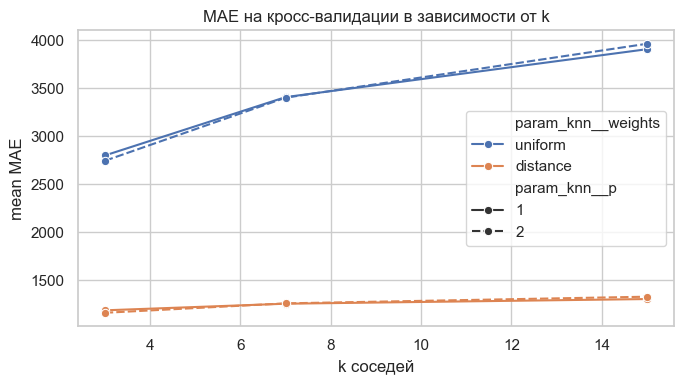

In [38]:
cv_results_reg = pd.DataFrame(reg_search.cv_results_)
cv_results_reg["param_knn__n_neighbors"] = cv_results_reg["param_knn__n_neighbors"].astype(
    int
)

plt.figure(figsize=(7, 4))
sns.lineplot(
    data=cv_results_reg,
    x="param_knn__n_neighbors",
    y=-cv_results_reg["mean_test_score"],
    hue="param_knn__weights",
    style="param_knn__p",
    marker="o",
)
plt.title("MAE на кросс-валидации в зависимости от k")
plt.xlabel("k соседей")
plt.ylabel("mean MAE")
plt.tight_layout()
plt.show()


Кастомный KNN для регрессии на компактной выборке\
Тестируем собственную реализацию с тем же препроцессингом

In [39]:
X_reg_small, _, y_reg_small, _ = train_test_split(
    features_reg, target_reg, train_size=1200, random_state=RANDOM_STATE
)

X_train_reg_small, X_test_reg_small, y_train_reg_small, y_test_reg_small = (
    train_test_split(
        X_reg_small, y_reg_small, test_size=0.2, random_state=RANDOM_STATE
    )
)

custom_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        ("model", CustomKNNRegressor(n_neighbors=7, p=2)),
    ]
)

custom_reg_pipeline.fit(X_train_reg_small, y_train_reg_small)
custom_reg_pred = custom_reg_pipeline.predict(X_test_reg_small)

results_regression["custom_knn"] = regression_report_dict(
    y_test_reg_small, custom_reg_pred
)

/Users/hedgefo9/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Диагностика регрессии: предсказания vs факты и остатки\
Сравниваем baseline и tuned по scatter-плотам и распределению ошибок

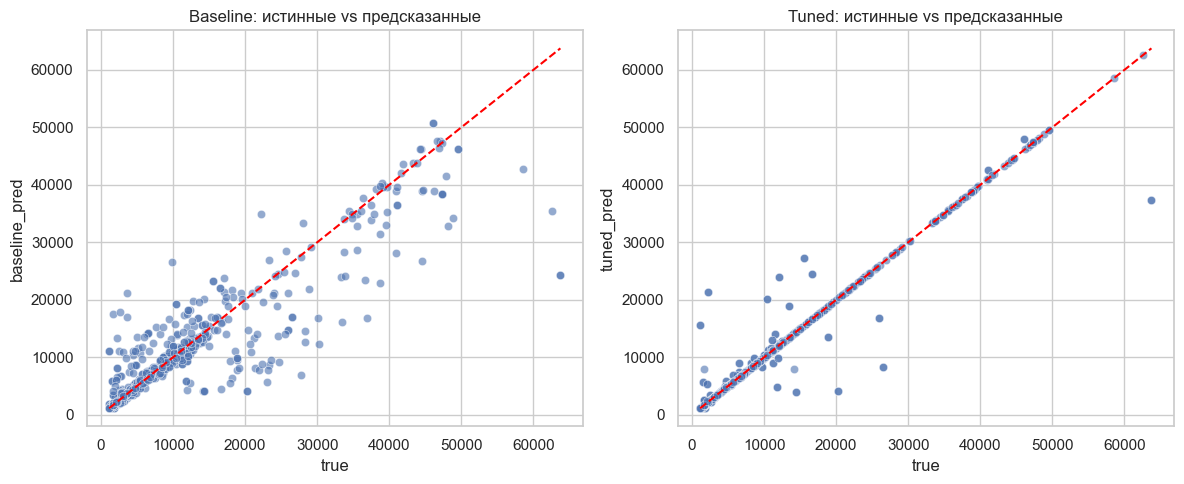

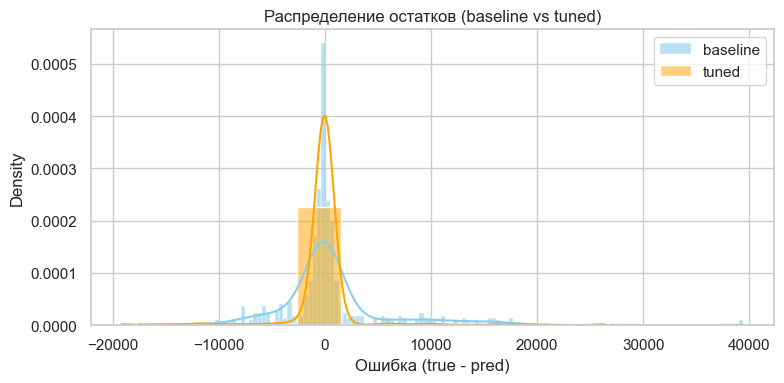


Метрики регрессии (страховые выплаты)
                    mae       rmse      r2
baseline_knn  2949.2502  5625.7776  0.7938
tuned_knn      784.4997  3125.5939  0.9363
custom_knn    4297.6748  7317.8616  0.5625


In [40]:
reg_eval_df = pd.DataFrame(
    {
        "true": y_test_reg,
        "baseline_pred": reg_pred,
        "tuned_pred": best_reg_pred,
    }
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    data=reg_eval_df.sample(len(reg_eval_df), random_state=RANDOM_STATE),
    x="true",
    y="baseline_pred",
    alpha=0.6,
    ax=axes[0],
)
axes[0].plot(
    [reg_eval_df["true"].min(), reg_eval_df["true"].max()],
    [reg_eval_df["true"].min(), reg_eval_df["true"].max()],
    color="red",
    linestyle="--",
)
axes[0].set_title("Baseline: истинные vs предсказанные")

sns.scatterplot(
    data=reg_eval_df.sample(len(reg_eval_df), random_state=RANDOM_STATE),
    x="true",
    y="tuned_pred",
    alpha=0.6,
    ax=axes[1],
)
axes[1].plot(
    [reg_eval_df["true"].min(), reg_eval_df["true"].max()],
    [reg_eval_df["true"].min(), reg_eval_df["true"].max()],
    color="red",
    linestyle="--",
)
axes[1].set_title("Tuned: истинные vs предсказанные")
plt.tight_layout()
plt.show()

residuals_baseline = reg_eval_df["true"] - reg_eval_df["baseline_pred"]
residuals_tuned = reg_eval_df["true"] - reg_eval_df["tuned_pred"]

plt.figure(figsize=(8, 4))
sns.histplot(
    residuals_baseline,
    color="skyblue",
    label="baseline",
    kde=True,
    stat="density",
    alpha=0.6,
)
sns.histplot(
    residuals_tuned,
    color="orange",
    label="tuned",
    kde=True,
    stat="density",
    alpha=0.5,
)
plt.legend()
plt.title("Распределение остатков (baseline vs tuned)")
plt.xlabel("Ошибка (true - pred)")
plt.tight_layout()
plt.show()

show_results_table(results_regression, title="Метрики регрессии (страховые выплаты)")


## Выводы
Классификация: логистическая регрессия в базовом и тюнингованном вариантах дает устойчиво высокое AUC (около 0.96) и умеренный F1 (около 0.56). Кастомная реализация увеличила Accuracy и AUC, но снизила полноту и F1, поэтому стандартная логистика остается предпочтительной благодаря стабильности и интерпретируемости коэффициентов.

Регрессия: линейная регрессия и регуляризованные варианты (Ridge, Lasso) показали почти одинаковые результаты (MAE около 4160, R² около 0.74). Это указывает на близкую к линейной структуру данных и отсутствие заметной выгоды от регуляризации. Для повышения качества следует рассматривать нелинейные алгоритмы.
